# Birkhoff Averaging

This is an example of using the weighted Birkhoff averaging functions. Given a dynamical system $F : \mathbb{R}^d \to \mathbb{R}^d$, an observation function $h : \mathbb{R}^d \to \mathbb{R}^n$, and an initial point $x_0 \in \mathbb{R}^d$, the Birkhoff average is defined as
$$
B[h](x_0) \lim_{T\to\infty} \frac{1}{T}\sum_{t = 0}^{T-1} (h \circ F^t)(x_0).
$$
It has been shown in a series of articles (see [Sander and Meiss](https://arxiv.org/abs/2001.00086) and the citations within, as well as [Quantitative Periodicity](https://arxiv.org/abs/1601.06051) for more detailed statements) that if $h\in C^\infty$ and the trajectory starting at $x_0$ lies on a $C^\infty$ invariant circle or island chain, the Birkhoff average can be improved via weighting. Particularly, the formula is given by
$$
WB[h](x_0) = \lim_{T\to\infty} \sum_{t = 0}^{T-1} w_{t,T} (h \circ F^t)(x_0),
$$
where $w_{t,T}$ is found by sampling a smooth windowing function $\alpha \in C^\infty$ with $\mathrm{supp}(\alpha) = [0,1]$ as
$$
w_{t,T} = \frac{1}{S} \alpha \left(\frac{t}{T+1}\right), \qquad S = \sum_{t = 1}^T \alpha \left(\frac{t}{T+1}\right).
$$
When this average is performed on a smooth integrable trajectory, the error is $\mathcal{O}(T^{-M})$ for all $M$. Otherwise, in chaos, the error goes as $\mathcal{O}(T^{-1/2})$.

In this document, we show how trajectories of the standard map can be classified via the convergence of a period-doubling adaptive version of this algorithm. Following Sander and Meiss, we consider the finite weighted Birkhoff average as
$$
WB_T[h](x_0) =  \sum_{t = 0}^{T-1} w_{t,T} (h \circ F^t)(x_0).
$$
Then, we consider the algorithm to be converged if $| WB_{2T} - WB_T | < \epsilon$ for some tolerance $\epsilon$. This can be performed in $\mathcal{O}(T \log T)$ time by taking the Birkhoff average after every doubling of $T$.

We will work with he standard map $F : (x_t, y_t) \mapsto (x_{t+1}, y_{t+1})$, given by
$$
\begin{aligned}
    x_{t+1} &= x_t + y_{t+1} \mod 1, \\
    y_{t+1} &= y_t - \frac{k}{2\pi} \sin(2\pi x_t).
\end{aligned}
$$
We will average over the quantity $h(x,y) = y$. The average of this quantity gives the rotational transform of the invariant circle (NOTE: here we distinguish between rotational transform and rotation number, where rotational transform is defined as the twist around the torus and rotation number would be defined off of a ).

First, we show an example of calling the finite weighted Birkhoff average. By changing $T$, one can adjust the accuracy of the average. By changing $x_0$, one can choose between chaos and not chaos.

In [1]:
using Revise
using SymplecticMapTools
using CairoMakie
using Sobol

The rotation number (Birkhoff average) is 0.49995594952937555


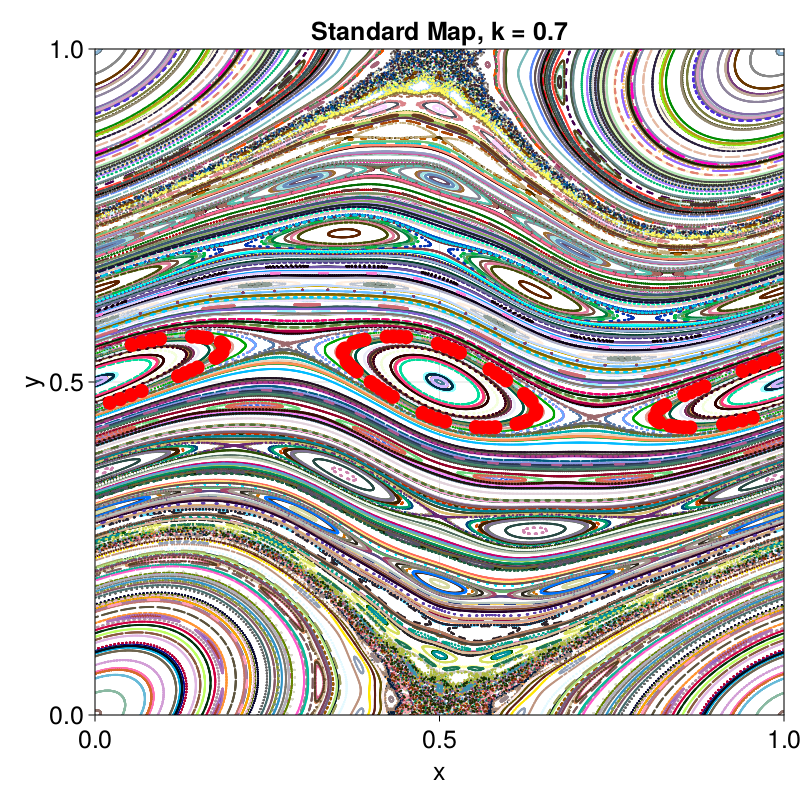

In [2]:
k_sm = 0.7;
F = standard_map_F(k_sm);

T = 100
x0 = [0.4, 0.5]; # Invariant Circle
# x0 = [0.49, 0.0]; # Chaos


xs = zeros(2, T);
xs[:, 1] = x0
hs = zeros(T);
hs[1] = x0[2];
for ii = 2:T
    xs[:,ii] = F(xs[:,ii-1])
    hs[ii] = xs[2, ii]
end

# Find the Average
ave = weighted_birkhoff_average(hs)
println("The rotation number (Birkhoff average) is $(ave)")

# Plot the trajectory on the standard map
f, xs_pp = poincare_plot([0,1], [0,1], F, 500, 1000, title="Standard Map, k = $(k_sm)")
ax = contents(f[1, 1])
plot!(xs[1,:], xs[2,:], color=:red, markersize=20)

f

We see that the rotation number for the trajectory above is close to $0.5$. This makes sense, because the island chain has two circles.

In order to show that the convergence is dependent on the initial orbit, we reproduce a figure from Sander and Meiss. Given a set of initial points on the standard map, we will plot $WB_T$ vs $T$, showing the separation.

In [3]:
# Get averages at each $T$ in the sorted list of integers $T$
function get_averages(F, h, x0, Ts)
    NT = length(Ts); Tmax = maximum(Ts)
    aves = zeros(NT); xs = zeros(2, Tmax); hs = zeros(Tmax)
    xs[:,1] = x0; hs[1] = h(x0)

    jj = 1
    for t = 2:Tmax
        xs[:, t] = F(xs[:, t-1]); hs[t] = h(xs[:,t])

        if t == Ts[jj]
            aves[jj] = weighted_birkhoff_average(hs[1:Ts[jj]]); jj = jj+1
        end
    end

    return xs, aves
end

get_averages (generic function with 1 method)

┌ Warning: Assignment to `xs` in soft scope is ambiguous because a global variable by the same name exists: `xs` will be treated as a new local. Disambiguate by using `local xs` to suppress this warning or `global xs` to assign to the existing global variable.
└ @ /mnt/c/Users/mer335/Documents/GitHub/SymplecticMapTools.jl/examples/birkhoff_averaging.ipynb:18


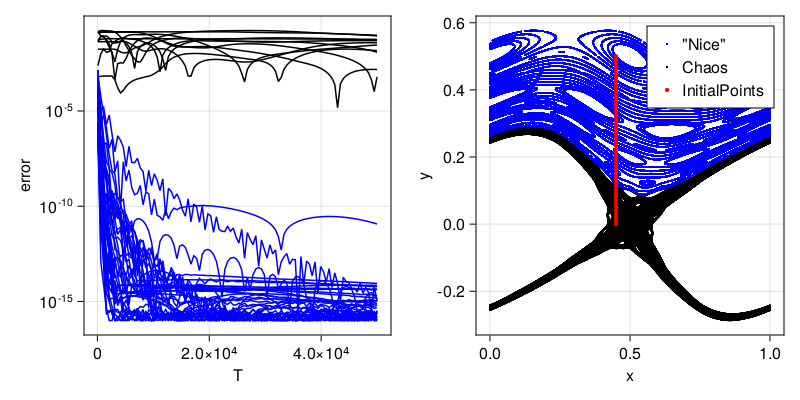

In [4]:
h = (x) -> x[2];

# T values to use
Tmin = 100; Tmax = 50000; NT = 100;
Ts = Int.(floor.(LinRange(Tmin, Tmax, NT)))
Ts = vcat(Ts, Tmax*2) # This is the "true" value

# Initial Points
Ny = 50; ys = LinRange(0, 0.5, Ny);

# Create figure
f = CairoMakie.Figure(resolution=(800,400));
ax1 = CairoMakie.Axis(f[1,1],  yscale=log10, xlabel="T", ylabel="error");
ax2 = CairoMakie.Axis(f[1,2], xlabel="x", ylabel="y");

# Loop over trajectories
for (jj, y) in enumerate(ys)
    xs, aves = get_averages(F, h, [0.45, y], Ts)
    errs = abs.(aves[1:end-1] .- aves[end])

    color = errs[end] < 1e-10 ? :blue : :black
    label = errs[end] < 1e-10 ? "\"Nice\"" : "Chaos"
    CairoMakie.lines!(ax1, Ts[1:end-1], errs[:] .+ 1e-16; color);
    CairoMakie.scatter!(ax2, xs[1, :], xs[2, :]; color, markersize=2, label);
end
CairoMakie.scatter!(ax2, ones(Ny).*0.45, ys; color=:red, markersize=6, label="InitialPoints")
axislegend(ax2, merge=true)

display(f);

We see that we successfully distinguish between "nice" trajectories like invariant circles and islands and chaotic ones. We can then use this with the adaptive average to categorize trajectories.

T_max = 32000
┌ Warning: Assignment to `ave` in soft scope is ambiguous because a global variable by the same name exists: `ave` will be treated as a new local. Disambiguate by using `local ave` to suppress this warning or `global ave` to assign to the existing global variable.
└ @ /mnt/c/Users/mer335/Documents/GitHub/SymplecticMapTools.jl/examples/birkhoff_averaging.ipynb:10
┌ Warning: Assignment to `xs` in soft scope is ambiguous because a global variable by the same name exists: `xs` will be treated as a new local. Disambiguate by using `local xs` to suppress this warning or `global xs` to assign to the existing global variable.
└ @ /mnt/c/Users/mer335/Documents/GitHub/SymplecticMapTools.jl/examples/birkhoff_averaging.ipynb:10
┌ Warning: Assignment to `hs` in soft scope is ambiguous because a global variable by the same name exists: `hs` will be treated as a new local. Disambiguate by using `local hs` to suppress this warning or `global hs` to assign to the existing global variable.

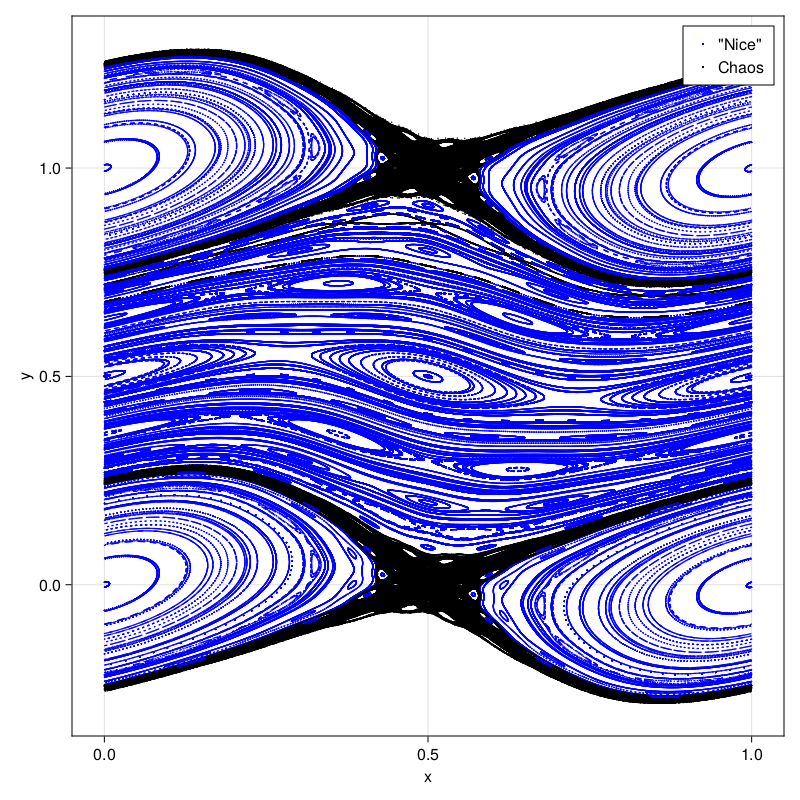

In [5]:
# Create a figure that categorizes trajectories as chaotic or not-chaotic.
s = SobolSeq([0,0],[1,1]);
N_init = 250;
T_init = 250; T_max = (2^7)*T_init
println("T_max = $(T_max)")

f = Figure(resolution=(800,800))
ax = Axis(f[1,1], xlabel="x", ylabel="y");
for ii = 1:N_init
    ave, xs, hs, conv_flag = doubling_birkhoff_average(h, F, next!(s); T_init, T_max)

    color = conv_flag ? :blue      : :black
    label = conv_flag ? "\"Nice\"" : "Chaos"
    CairoMakie.scatter!(ax, xs[1, :], xs[2, :]; color, markersize=2, label);
end
axislegend(ax, merge=true)

f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*